<a href="https://colab.research.google.com/github/shi3z/neuralevoltionlab/blob/main/neuroevolutionlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=67646e1f52205ad22a2cbd5a6cd984166f737dcb560cf84d4cfed983cff977ab
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
# Generic Architecture Search
import random
class Gene:
    length=10

    def __init__(self,DNA=None):
        if DNA is None:
            DNA=""
            for i in range(Gene.length):
                DNA += str(random.randint(0,5))
        self.DNA=DNA

    def cross(self,anotherGene,rate=50):
        DNA=list(self.DNA)
        for i in range(Gene.length):
            if random.randint(0,100)<rate:
                DNA[i]=anotherGene.DNA[i] # ReplaceDNA
        DNA="".join(DNA)
        return DNA



from torchviz import make_dot
#from IPython.display import display

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)

class Organism():
    def __init__(self,gene):
        super().__init__()
        self.gene = gene
        self.layers=[]

    def embody(self):
        def neuralCell(type=None,in_ch=10,out_ch=10):
                if type=="0":
                    return f"nn.Conv2d({in_ch}, {out_ch}, kernel_size=5, padding='same')"
                if type=="1":
                    return f"nn.Conv2d({in_ch}, {out_ch}, kernel_size=3,  padding='same')"
                if type=="2":
                    return f"nn.Conv2d({in_ch}, {out_ch}, kernel_size=7,  padding='same')"
                if type=="3":
                    return f"nn.Conv2d({in_ch}, {out_ch}, kernel_size=7,  padding='same')"
                if type=="4":
                    return f"nn.Conv2d({in_ch}, {out_ch}, kernel_size=1,  padding='same')"
                return f"nn.Conv2d({in_ch}, {out_ch}, kernel_size=4,  padding='same')"


        code=f"""
class NN(nn.Module):
\tdef __init__(self):
\t\tsuper().__init__()
\t\tself.l0 = nn.Conv2d(1, 10, kernel_size=3,  padding='same')
"""

        def get_ch_no(no):
            return (int(self.gene.DNA[no])//2+1)*10

        in_ch = 10

        for i in range(Gene.length//2):
            out_ch=get_ch_no(i)
            code += "\t\tself.l%d = %s\n"%(i+1,neuralCell(self.gene.DNA[i],in_ch,out_ch) )
            in_ch=out_ch
        code+="""
\tdef forward(self,x):
\t\tx0=x.view(-1, 1, 28, 28)
"""
        for i,j in zip(range(Gene.length//2),range(Gene.length//2,Gene.length)):
            t = self.gene.DNA[j]
            if t=="0":
                code += f"\t\tx{i+1} = self.l{i}(x{i})\n"
            elif i>0:
                k = i-1
                if t=="1":
                    k=i-1
                elif t=="2" and i>1:
                    k=i-2
                elif t=="3" and i>2:
                    k=i-3
                elif t=="4" :
                    k=0
                elif t=="5" and i>1:
                    k=1


                in1_ch=get_ch_no(i)
                in2_ch=get_ch_no(k)

                if in1_ch == in2_ch:
                    code += f"\t\tx{i+1} = F.relu(self.l{i}(x{i}))+x{k}\n"
                else:
                    code += f"\t\tx{i+1} = F.relu(self.l{i}(x{i}))*torch.mean(x{k})\n"
            else:
                code += f"\t\tx{i+1} = F.relu(self.l{i}(x{i}))\n"
            #code+=f"\t\tprint(x{i+1}.shape)\n"

        code+=f"\t\tx{i+1}=F.adaptive_avg_pool2d(x{i+1}, (1, 1))\n"

        code += f"\t\treturn x{i+1}.view(-1, x{i+1}.size(1))\n"
        print(code)

        bytecode=compile(code,'<string>','exec')
        exec(bytecode,globals())
        self.body = NN()
        model = NN()

        x = torch.randn(1,1, 28*28)
        y = model(x)
        img=make_dot(y, params=dict(model.named_parameters()))
        display(img)
        #print(img)
        #display(img)
        return self.body


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


import numpy as np

def loss_batch(model, loss_func, xb, yb, opt=None):
    xb = xb.to(device)
    yb = yb.to(device)
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
    return val_loss


parents=[   ("1325103404","Izanagi","Chamion"),
            ("0012250013","Izanami","Elite"),
            ("3515433210","Susanoo","Rogue"),
            ("0414255400","Ninigi","Ordinary"),
            ("1434041234","Sakuya","Work hard"),
            ("1112351540","Omoikane","Genius")
            ]
species=[]
min_loss=100
champion=None
criterion = nn.CrossEntropyLoss()


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



イザナギ x イザナミ 0
1015153013

class NN(nn.Module):
	def __init__(self):
		super().__init__()
		self.l0 = nn.Conv2d(1, 10, kernel_size=3,  padding='same')
		self.l1 = nn.Conv2d(10, 10, kernel_size=5, padding='same')
		self.l2 = nn.Conv2d(10, 20, kernel_size=7,  padding='same')
		self.l3 = nn.Conv2d(20, 20, kernel_size=7,  padding='same')
		self.l4 = nn.Conv2d(20, 30, kernel_size=4,  padding='same')
		self.l5 = nn.Conv2d(30, 20, kernel_size=7,  padding='same')

	def forward(self,x):
		x0=x.view(-1, 1, 28, 28)
		x1 = F.relu(self.l0(x0))
		x2 = self.l1(x1)
		x3 = F.relu(self.l2(x2))*torch.mean(x0)
		x4 = F.relu(self.l3(x3))*torch.mean(x2)
		x5 = F.relu(self.l4(x4))+x1
		x5=F.adaptive_avg_pool2d(x5, (1, 1))
		return x5.view(-1, x5.size(1))

イザナギ x イザナミ 1
0025103404

class NN(nn.Module):
	def __init__(self):
		super().__init__()
		self.l0 = nn.Conv2d(1, 10, kernel_size=3,  padding='same')
		self.l1 = nn.Conv2d(10, 10, kernel_size=3,  padding='same')
		self.l2 = nn.Conv2d(10, 10, kernel_size=5, p

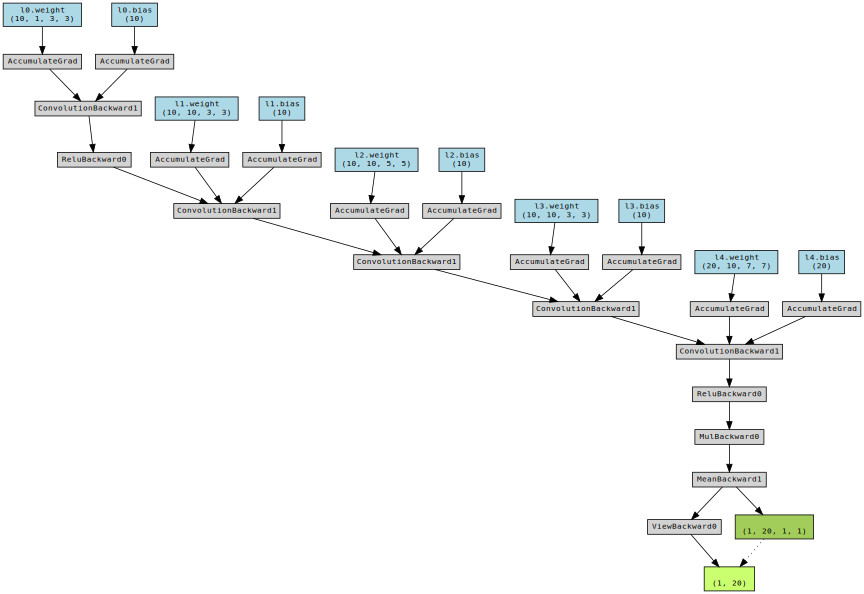

DNA:1012250004 start sprint
0 2.2661287185668946


In [ ]:

for father in parents:
    for mother in parents:
        if father[0]==mother[0]:
            continue

        for bros in range(5):
            print(f"{father[1]} x {mother[1]} {bros}")

            a = Gene(father[0])
            b = Gene(mother[0])
            c = Gene(a.cross(b))
            child = Organism(c)
            try:
                net = child.embody().to(device)
                optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
                print(f"DNA:{c.DNA} start sprint")
                loss = fit(5, net, criterion, optimizer, trainloader, testloader)
                Species.append([loss,c])
                if min_loss>loss:
                    min_loss = loss
                    champion = c
            except:
                pass
